In [1]:
import psycopg2
import pandas as pd
import psycopg2.extras
import seaborn as sns
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
class PostgresConnection(object):
    def __init__(self):
        self.connection = psycopg2.connect(database="hddb",
                                           user = "postgres",
                                           password = "suPer2k23",
                                           host = "127.0.0.1",
                                           port = "5432")

    def getConnection(self):
        print("successfully connected to database")
        return self.connection

In [4]:
con = PostgresConnection().getConnection()

successfully connected to database


In [10]:
def changetype(x):
    x['sales']=x['sales'].astype('float64') 

# 1. Find Hospital wise sales

In [73]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT h.hospital_name, SUM(ft.sales_price) as sales "\
"FROM hddb_star_schema.fact_table ft "\
"JOIN hddb_star_schema.hospital_dim h ON h.hospital_key = ft.hospital_key "\
"GROUP BY CUBE(h.hospital_name) "\
"ORDER BY h.hospital_name "
cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [74]:
records

[('BANGLADESH EYE HOSPITAL LTD.', Decimal('87154050')),
 (None, Decimal('87154050'))]

In [75]:
hospital_wise = pd.DataFrame(records, columns=['hospital_name', 'sales'])
hospital_wise



,hospital_name,sales
0,BANGLADESH EYE HOSPITAL LTD.,87154050
1,None,87154050


In [83]:
hospital_wise = hospital_wise[0:1]
hospital_wise

,sales
hospital_name,
BANGLADESH EYE HOSPITAL LTD.,87154050


# 2. Find division wise sales in Bangladesh Eye Hospital Ltd.


In [7]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT g.division, SUM(ft.sales_price) as sales "\
"FROM hddb_star_schema.fact_table ft "\
"JOIN hddb_star_schema.hospital_dim h ON h.hospital_key = ft.hospital_key "\
"JOIN hddb_star_schema.geography_dim g ON g.geo_key = ft.geo_key "\
"WHERE ft.hospital_key = '100001' "\
"GROUP BY CUBE(g.division) "

cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [8]:
records

[(None, Decimal('87154050')),
 ('RAJSHAHI', Decimal('5447120')),
 ('DHAKA', Decimal('55565810')),
 ('CHITTAGONG', Decimal('9669200')),
 ('BARISAL', Decimal('3430130')),
 ('KHULNA', Decimal('4851240')),
 ('RANGPUR', Decimal('4758500')),
 ('SYLHET', Decimal('3432050'))]

In [9]:
division_wise = pd.DataFrame(records, columns=['division', 'sales'])
division_wise

,division,sales
0,None,87154050
1,RAJSHAHI,5447120
2,DHAKA,55565810
3,CHITTAGONG,9669200
4,BARISAL,3430130
5,KHULNA,4851240
6,RANGPUR,4758500
7,SYLHET,3432050


In [11]:
changetype(division_wise)
division_wise.dtypes

division     object
sales       float64
dtype: object

In [12]:
sorted_sales = division_wise
sorted_sales.sort_values(by=['sales'],inplace=True,ascending=False)
sorted_sales

,division,sales
0,None,87154050.0
2,DHAKA,55565810.0
3,CHITTAGONG,9669200.0
1,RAJSHAHI,5447120.0
5,KHULNA,4851240.0
6,RANGPUR,4758500.0
7,SYLHET,3432050.0
4,BARISAL,3430130.0


In [13]:
top_sales = sorted_sales[1:7]
top_sales

,division,sales
2,DHAKA,55565810.0
3,CHITTAGONG,9669200.0
1,RAJSHAHI,5447120.0
5,KHULNA,4851240.0
6,RANGPUR,4758500.0
7,SYLHET,3432050.0


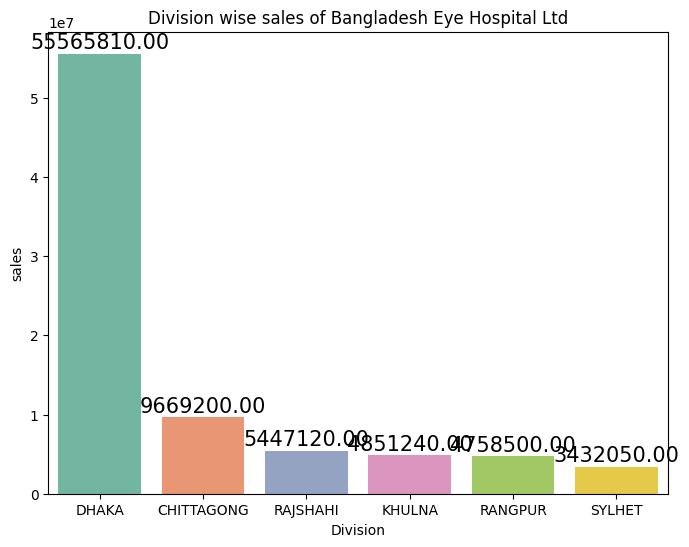

In [16]:
plt.figure(figsize=(8,6))
plots = sns.barplot(x=top_sales['division'],y=top_sales['sales'],palette="Set2")

for bar in plots.patches:
    plots.annotate(format(bar.get_height(),'.2f'),
                   (bar.get_x() + bar.get_width()/2,
                   bar.get_height()),ha='center',va='center',
                   size=15,xytext=(0, 8),
                   textcoords='offset points')
    
                   
                  
plt.xlabel('Division')
plt.ylabel('sales')
plt.title('Division wise sales of Bangladesh Eye Hospital Ltd')                        
plt.show()       

# 3. Which labs do not have any test in month 2?

In [52]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "WITH lab_sales AS (SELECT l.lab_name "\
"FROM hddb_star_schema.fact_table ft "\
"JOIN hddb_star_schema.lab_dim l ON l.lab_key = ft.lab_key "\
"JOIN hddb_star_schema.time_dim t ON t.time_key = ft.time_key "\
"WHERE t.month = '2' "\
"GROUP BY CUBE(l.lab_name) ) "\
"SELECT l.lab_name FROM hddb_star_schema.lab_dim as l EXCEPT SELECT ls.lab_name FROM lab_sales as ls "

cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [53]:
records

[('CT-SCAN',),
 ('Cardiology',),
 ('PSYCOTHERAPY',),
 ('LASER CENTRE  ',),
 ('TRAINING & DEVELOPMENT',),
 ('FLOOR (WARD/CABIN)',),
 ('CORONARY CARE UNIT (CCU)',),
 ('Transfusion Medicine',),
 ('PCA Service (FLOOR)',),
 ('BRONCOSCOPY',),
 ('ADMINISTRATION',),
 ('Internal Audit',),
 ('CUSTOMER SERVICES',),
 ('Dentistry',),
 ('SERVICE (COLLECTION)',),
 ('LABORATORY',),
 ('Surgery',),
 ('NICU',),
 ('Oral and Maxillofacial Surgery',),
 ('Endocrinology',),
 ('PATHOLOGY',),
 ('PLUMBING',),
 ('LIFT',),
 ('NICU (INCUBATOR)',),
 ('HR & Administration',),
 ('ORTHOPEDICS OT',),
 ('LAUNDRY & WASHING',),
 ('PHARMACOGENETICS LAB',),
 ('NEURO PSYCHIATRIST',),
 ('Surgical Oncology',),
 ('Safety & Security',),
 ('ANAESTHESIOLOGY',),
 ('INTERNAL AUDIT',),
 ('CARDIOLOGY VASCULAR',),
 ('GAS PLANT',),
 ('OPD DOCTORS',),
 ('CT-SCAN & MRI',),
 ('URO ONCOLOGY',),
 ('Neuro Medicine',),
 ('CARDIAC ICU',),
 ('Oncology',),
 ('PSYCHIATRY',),
 ('SUPPORT SERVICE',),
 ('Neuro Surgery',),
 ('PLASTIC & AESTHETIC OT',),


# 4. Show the top 5 tests in division Dhaka 

In [54]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT t.test_name, SUM(ft.sales_price) as sales "\
"FROM hddb_star_schema.fact_table ft "\
"JOIN hddb_star_schema.test_dim t ON t.test_key = ft.test_key "\
"JOIN hddb_star_schema.geography_dim g ON g.geo_key = ft.geo_key "\
"WHERE g.division = 'DHAKA' "\
"GROUP BY CUBE(t.test_name) " \
"ORDER BY sales DESC "

cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [55]:
records

[(None, Decimal('55565810')),
 ('Electrolytes Serum', Decimal('4823060')),
 ('CBC', Decimal('3504400')),
 ('Vitamin D3 / Vitamin-D (25,OH Cholecalciferol)', Decimal('2579720')),
 ('CRP (C-Reactive Protein)', Decimal('2545400')),
 ('Serum creatinine level', Decimal('2184480')),
 ('TSH', Decimal('1879130')),
 ('Renal Function Test (Urea, Creatinine, Electrolytes)', Decimal('1850200')),
 ('Blood for C/S', Decimal('1742400')),
 ('HbA1c', Decimal('1696200')),
 ('Grouping + Cross Matching + Screening', Decimal('1544400')),
 ('ALT(SGPT) Serum', Decimal('1103380')),
 ('Urine for C/S', Decimal('1097350')),
 ('Lipid Profile Serum (F)', Decimal('971500')),
 ('NT Pro BNP', Decimal('965580')),
 ('Serum Procalcitonin', Decimal('847000')),
 ('Platelet Apheresis', Decimal('847000')),
 ('Gastric lavage for Biochemistry', Decimal('833800')),
 ('Magnesium Serum', Decimal('830530')),
 ('Troponin I', Decimal('819250')),
 ('Complete Urine Analysis (Urine R/E)', Decimal('793800')),
 ('Anti-HCV', Decimal('784

In [56]:
test_wise = pd.DataFrame(records, columns=['test_name', 'sales'])
test_wise

,test_name,sales
0,None,55565810
1,Electrolytes Serum,4823060
2,CBC,3504400
3,"Vitamin D3 / Vitamin-D (25,OH Cholecalciferol)",2579720
4,CRP (C-Reactive Protein),2545400
...,...,...
407,Urobilinogen - Urine,240
408,Haemoglobin - Urine,240
409,Glucose Before Lunch Blood,240
410,Glucose Before Dinner Blood,240


In [57]:
changetype(test_wise)
test_wise.dtypes
sorted_sales = test_wise
sorted_sales.sort_values(by=['sales'],inplace=True,ascending=False)
sorted_sales

,test_name,sales
0,None,55565810.0
1,Electrolytes Serum,4823060.0
2,CBC,3504400.0
3,"Vitamin D3 / Vitamin-D (25,OH Cholecalciferol)",2579720.0
4,CRP (C-Reactive Protein),2545400.0
...,...,...
407,Urobilinogen - Urine,240.0
408,Haemoglobin - Urine,240.0
409,Glucose Before Lunch Blood,240.0
410,Glucose Before Dinner Blood,240.0


In [59]:
top_sales = sorted_sales[1:6]
top_sales

,test_name,sales
1,Electrolytes Serum,4823060.0
2,CBC,3504400.0
3,"Vitamin D3 / Vitamin-D (25,OH Cholecalciferol)",2579720.0
4,CRP (C-Reactive Protein),2545400.0
5,Serum creatinine level,2184480.0


<Axes: ylabel='sales'>

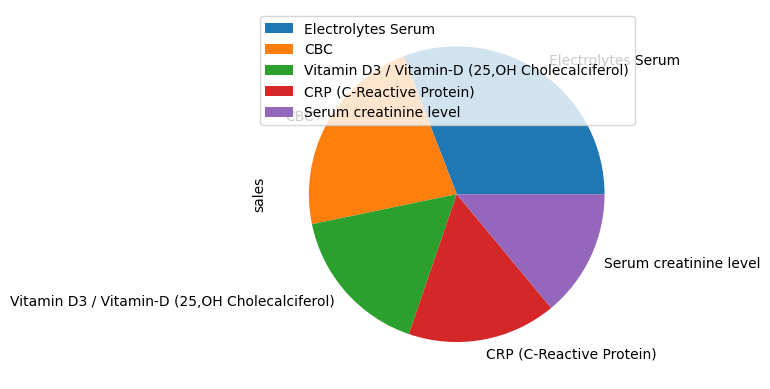

In [63]:
top_sales=top_sales.set_index(['test_name'])
top_sales.plot.pie( y='sales')

# 5. Show quarter wise sales in division Dhaka

In [64]:
con = PostgresConnection().getConnection()
cur = con.cursor()
select_stmt = "SELECT t.quarter, SUM(ft.sales_price) as sales "\
"FROM hddb_star_schema.fact_table ft "\
"JOIN hddb_star_schema.time_dim t ON t.time_key = ft.time_key "\
"JOIN hddb_star_schema.geography_dim g ON g.geo_key = ft.geo_key "\
"WHERE g.division = 'DHAKA' "\
"GROUP BY CUBE(t.quarter) "

cur.execute(select_stmt)
records = cur.fetchall()

successfully connected to database


In [65]:
records

[(None, Decimal('55565810')),
 ('Q3', Decimal('11183740')),
 ('Q2', Decimal('11886360')),
 ('Q4', Decimal('12926500')),
 ('Q1', Decimal('19569210'))]

In [66]:
quarter_wise = pd.DataFrame(records, columns=['quarter', 'sales'])
quarter_wise
changetype(quarter_wise)
quarter_wise.dtypes
sorted_sales = quarter_wise
sorted_sales.sort_values(by=['sales'],inplace=True,ascending=False)
sorted_sales

,quarter,sales
0,None,55565810.0
4,Q1,19569210.0
3,Q4,12926500.0
2,Q2,11886360.0
1,Q3,11183740.0


In [67]:
top_sales = sorted_sales[1:5]
top_sales

,quarter,sales
4,Q1,19569210.0
3,Q4,12926500.0
2,Q2,11886360.0
1,Q3,11183740.0


<Axes: ylabel='sales'>

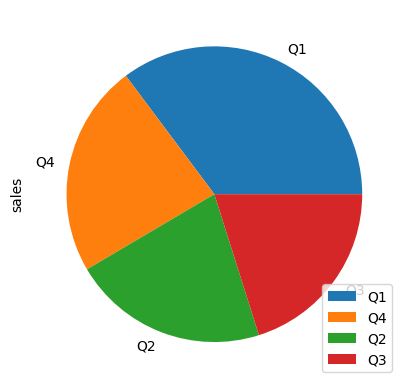

In [68]:
top_sales=top_sales.set_index(['quarter'])
top_sales.plot.pie( y='sales')